In [6]:
from covid19.datasets import RnboGovUa

data_frame = RnboGovUa().prepare(RnboGovUa.metrics, country_filter=['Ukraine'])
data_frame = data_frame.set_index('date')
print(data_frame.head(5))

2021-02-08 19:55:29,602 INFO |covid19.datasets| Dataset range: 2020-04-01 00:00:00 - 2021-02-07 00:00:00


            idx  country           region  deaths  delta_suspicion  \
date                                                                 
2020-04-01    0  Ukraine        Vinnytsia       0               17   
2020-04-01    0  Ukraine         Volynska       0               50   
2020-04-01    0  Ukraine  Dnipropetrovska       0               13   
2020-04-01    0  Ukraine         Donetska       0               12   
2020-04-01    0  Ukraine      Zhytomyrskа       1                6   

            delta_deaths  delta_existing  delta_confirmed  recovered  \
date                                                                   
2020-04-01             0               9                9          0   
2020-04-01             0               3                3          0   
2020-04-01             0               1                1          1   
2020-04-01             0               1                1          0   
2020-04-01             0               1                1          0   

    

In [16]:
data_confirmed = data_frame[['confirmed']]
data_confirmed = data_confirmed.groupby('date').sum('confirmed')
print(data_confirmed.head(5))

            confirmed
date                 
2020-04-01        794
2020-04-02        897
2020-04-03       1072
2020-04-04       1225
2020-04-05       1251


In [57]:
# inserting new column with yesterday's consumption values
data_confirmed.loc[:,'yesterday'] = data_confirmed.loc[:,'confirmed'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_confirmed.loc[:,'yesterday_diff'] = data_confirmed.loc[:,'yesterday'].diff()
n = data_confirmed['yesterday_diff'].min()
x = data_confirmed['yesterday_diff'].max()
print(f'yesterday_diff min: {n} max: {x}')

# dropping NAs
data_confirmed = data_confirmed.dropna()
print(data_confirmed.head(5))

yesterday_diff min: 259.0 max: 16294.0
            confirmed  yesterday  yesterday_diff
date                                            
2020-04-11       2511     2227.0           335.0
2020-04-12       2801     2511.0           284.0
2020-04-13       3104     2801.0           290.0
2020-04-14       3420     3104.0           303.0
2020-04-15       3764     3420.0           316.0


In [30]:
from datetime import timedelta, datetime
forecast_horizon = 7
dt = datetime.now() - timedelta(days=forecast_horizon + 1)

X_train = data_confirmed[:dt].drop(['confirmed'], axis = 1)
print(X_train.tail(5))
y_train = data_confirmed.loc[:dt, 'confirmed']
print(y_train.tail(5))

            yesterday  yesterday_diff
date                                 
2021-01-27  1197107.0          2779.0
2021-01-28  1200883.0          3776.0
2021-01-29  1206412.0          5529.0
2021-01-30  1211593.0          5181.0
2021-01-31  1216278.0          4685.0
date
2021-01-27    1200883
2021-01-28    1206412
2021-01-29    1211593
2021-01-30    1216278
2021-01-31    1219455
Name: confirmed, dtype: int64


In [31]:
X_test = data_confirmed[dt:].drop(['confirmed'], axis = 1)
print(X_test.head(forecast_horizon))
y_test = data_confirmed.loc[dt:, 'confirmed']
print(y_test.head(forecast_horizon))

            yesterday  yesterday_diff
date                                 
2021-02-01  1219455.0          3177.0
2021-02-02  1221485.0          2030.0
2021-02-03  1223879.0          2394.0
2021-02-04  1227164.0          3285.0
2021-02-05  1232246.0          5082.0
2021-02-06  1237169.0          4923.0
2021-02-07  1241479.0          4310.0
date
2021-02-01    1221485
2021-02-02    1223879
2021-02-03    1227164
2021-02-04    1232246
2021-02-05    1237169
2021-02-06    1241479
2021-02-07    1244849
Name: confirmed, dtype: int64


In [32]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

In [35]:
import sklearn.metrics as metrics
import numpy as np

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

LR: 0.984510 (0.019599)
NN: 0.984252 (0.019736)
KNN: -12.316183 (3.470529)
RF: -9.806971 (4.120765)
SVR: -4139.433657 (8989.177991)


/Users/denis/projects/tfs-covid19/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


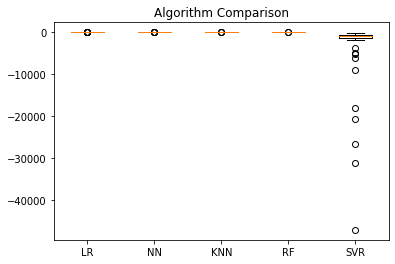

In [60]:
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=50)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)


model = RandomForestRegressor()
param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print(best_model)

RandomForestRegressor(max_depth=11, n_estimators=20)


In [49]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.3495
mean_squared_log_error:  0.0003
r2:  -4.5796
MAE:  18366.0929
MSE:  381825407.6682
RMSE:  19540.3533
